# Code used to generate the paper figures
This notebook contains the code used to generate the paper figures. 
It includes:
 - the code to generate the heatmaps/plots for LIME image with/without stratification
 - the code to generate the plots with the binomial distribution and the Shapley weight function
 - the plot to generate the comparison tables in the Experimental section, starting from the CSV file obtained from the long experiments.

In [1]:
import utils as ut
import numpy as np
import pandas as pd
import scipy.special
import json, math,cv2
import tensorflow as tf
import sys, os, importlib
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# Stretch Notebook Width to 98% size of the Screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
Main_dir        =   os.getcwd()
DS_path         =   os.path.join(Main_dir, "data")
result_folder   =   os.path.join(Main_dir, "result")
paper_figures   =   os.path.join(result_folder,"Paper_Figures")
json_file       =   os.path.join(DS_path,"imagenet_class_index.json")

ut.check_folders(result_folder)
ut.check_folders(paper_figures)

folder created:	C:\Users\rashi\lime-stratified-examples\result\Paper_Figures


In [3]:
# load pre-trained model and data
model_name = 'ResNet50'
model = ut.load_model(model_name=model_name)

BlackBox Model Selected: 		 ResNet50
BlackBox Model Layers Count: 		 177
BlackBox Model Weights Count: 		 320


In [4]:
# getting ImageNet class names
class_names = ut.get_ImageNet_ClassLabels(json_file) 

In [5]:
from lime_stratified.lime import lime_image
from lime_stratified.lime.lime_image import LimeImageExplainer
from lime_stratified.lime.wrappers.scikit_image import SegmentationAlgorithm

In [6]:
image_name = 'bird5'
file = os.path.join(DS_path,image_name+'.png')
image_to_explain = ut.read_process_image(file,model)

# Black-box prediction function
NOTE: depending on tensorflow version, this may require a change highlighted below. 

In [7]:
def bb_predict(imgs):
    # On some platform, you will need model.predict(..) instead of model(..)
    return model.predict(preprocess_input(imgs), verbose=False)
#     return model(preprocess_input(imgs))

In [8]:

predicted = bb_predict(np.array([image_to_explain]))

(predicted_cls_idx,f_x,predicted_cls_lbl) =  ut.get_class_idx_label_score (predicted,class_names)

# predicted_cls = np.argmax(predicted[0])
# f_x = predicted[0][predicted_cls]
print('Predicted Class\t\t: \t',predicted_cls_lbl,'\nClass Probability\t:\t', f_x,'\nPredicted Class Index\t:\t', predicted_cls_idx)

Predicted Class		: 	 indigo_bunting 
Class Probability	:	 0.99494475 
Predicted Class Index	:	 14


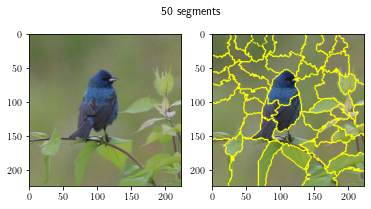

In [9]:
from matplotlib import rc
rc('text',usetex=True)

from skimage.segmentation import mark_boundaries
seg_algo = 'quickshift'
max_dist,_,_,_ = ut.search_segment_number(image_to_explain, target_seg_no=50)

segments,num_segments,segmenter_fn = ut.own_seg(image_to_explain,md=max_dist,ks=4,random_seed=1234,ratio=0.2)

fig,axes = plt.subplots(1,2, figsize=(6,3))
axes[0].imshow(image_to_explain)
axes[1].imshow(mark_boundaries(image_to_explain, segments))
plt.suptitle(f'{num_segments} segments')
plt.savefig(f'{paper_figures}/{image_name}_image_{num_segments}_segments.pdf', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.savefig(f'{paper_figures}/{image_name}_image_{num_segments}_segments.png', transparent=True,dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

In [10]:
lime_explainer = LimeImageExplainer(random_state=1234)              # Fixing Random state
use_stratification = True                                           # Boolean value to switch the proposed method to be used or not
ret = lime_explainer.explain_instance(image_to_explain,             # image being explained
                                      bb_predict,                   # prediction model 
                                      labels=class_names,           # classes names from ImageNet dataset
                                      segmentation_fn=segmenter_fn, # custom Segmenter function to generate exactly same superpixels
                                      top_labels=3,                 # top explanation
                                      hide_color=None,              # superpixel replacement strategy
                                      use_stratification=use_stratification, # Boolean value to switch the proposed method to be used or not 
                                      batch_size=100,               # batch size
                                      num_samples=1000)             # no of samples
X, all_Ys, expl = ret                                               # when return (data, labels, ret_exp)
Y = all_Ys[:, predicted_cls_idx]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
xpld_cls = expl.top_labels[0]
g_x = expl.local_pred[xpld_cls][0]
print('g(x) \t\t= ', g_x)
beta = ut.get_beta_from_expl(explanation=expl)
print('sum(beta) \t= ', np.sum(beta))
std_beta = np.std((beta))
mean_beta = np.mean((beta))
print('CV(beta) \t= ',std_beta/mean_beta)

g(x) 		=  1.131590787675231
sum(beta) 	=  0.7381478241056648
CV(beta) 	=  2.947321725850191


v = 0.16458989679813385


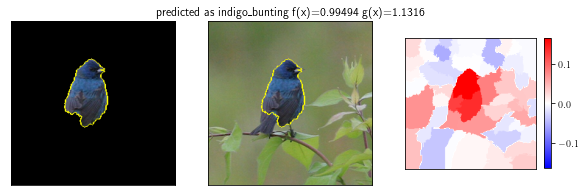

In [12]:
from skimage.segmentation import mark_boundaries
# def axis_off(ax):
#     ax.set_xticks([], []) ; ax.set_yticks([], [])
expl.image = image_to_explain
heatmap = ut.heatmap_from_beta(segments=segments, beta=beta) 
v = np.max(np.abs(heatmap))
print(f'v = {v}')

temp_1, mask_1 = expl.get_image_and_mask(expl.top_labels[0], positive_only=True, num_features=1000, hide_rest=True, min_weight=v/2)
temp_2, mask_2 = expl.get_image_and_mask(expl.top_labels[0], positive_only=True, num_features=1000, hide_rest=False, min_weight=v/2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.imshow(mark_boundaries(temp_1.astype(np.uint8), mask_1))
ax2.imshow(mark_boundaries(temp_2.astype(np.uint8), mask_2))

im = ax3.imshow(heatmap, cmap='bwr', vmin=-v, vmax=v)
fig.colorbar(im, ax=ax3, shrink=0.60)
ut.axis_off(ax1)
ut.axis_off(ax2)
ut.axis_off(ax3)
ax2.set_title(f'predicted as {class_names[predicted_cls_idx]}  f(x)={f_x:.5}  g(x)={g_x:.5}')
plt.savefig(f'{paper_figures}/{image_name}_image_mask_heatmap_single.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.savefig(f'{paper_figures}/{image_name}_image_mask_heatmap_single.pdf', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.savefig(f'{paper_figures}/{image_name}_image_mask_heatmap_single.png', transparent=True,dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()


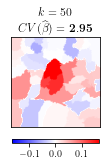

In [13]:
# Feature Importance Heatmap generated based on beta values
heatmap = ut.heatmap_from_beta(segments, beta) 
v = np.max(np.abs(heatmap))
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
im = ax.imshow(heatmap, cmap='bwr', vmin=-v, vmax=v)
fig.colorbar(im, ax=ax, shrink=0.55, orientation='horizontal', anchor=(.5, 1.5))
ut.axis_off(ax)
beta_title = '\\widehat{\\beta}' if use_stratification else '\\beta'
plt.title(f'$k = {num_segments}$ \n $CV({beta_title}) = \\mathbf{{ {ut.get_CV_beta(beta):.3} }}$')
plt.tight_layout()
plt.savefig(f'{paper_figures}/{image_name}_heatmap.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.savefig(f'{paper_figures}/{image_name}_heatmap.png', transparent=True,dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.show()

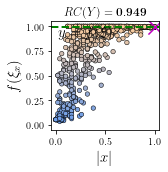

In [14]:
# Classification Score Plot
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
plt.gca().set_aspect('equal')
ut.plot_classification_score(ax, expl, X, Y, f_x)
plt.title(f'$RC(Y) = \\mathbf{{ {ut.get_RCY(Y, f_x):.3} }}$')
plt.tight_layout()
plt.savefig(f'{paper_figures}/{image_name}_RC_Y.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
plt.savefig(f'{paper_figures}/{image_name}_RC_Y.png', dpi=150, bbox_inches='tight', pad_inches=0.02)


# Generate the plot for the binomial distribution and the Shapley weight function (Figure 3)

0.0009765625
9.5367431640625e-07
8.881784197001252e-16
0.00036075036075036075
2.5774019582069117e-07
1.5511232553820811e-16


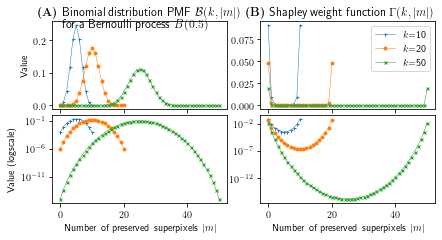

In [15]:
plt.rcParams.update({"text.usetex": True })
N = 100 # segments
markers = ['+','o','x']
fig,axes = plt.subplots(2,2, figsize=(6, 3.2), sharex=True)
for ii, k in enumerate([10, 20, 50]):
    MD = [ut.pdf_bern(k, s) for s in range(k+1)]
    print(np.min(MD))
    axes[0,0].plot(range(k+1), MD, marker=markers[ii], markersize=3, label=f'$k$={k}', lw=.5)
    axes[1,0].plot(range(k+1), MD, marker=markers[ii], markersize=3, label=f'$k$={k}', lw=.5)
axes[0,0].set_title('\\noindent {\\bf (A)} Binomial distribution PMF $\\mathcal{B}(k, |m|)$\\\\ \\phantom{niim} for a Bernoulli process $B(0.5)$')#, loc='center')
axes[1,0].set_xlabel('Number of preserved superpixels $|m|$')
axes[1,0].set_yscale('log')
axes[0,0].set_ylabel('Value')
axes[1,0].set_ylabel('Value (logscale)')
for ii, k in enumerate([10, 20, 50]):
    MD = [ut.shapley_p(k, s) for s in range(k+1)]
    print(np.min(MD))
    axes[0,1].plot(range(k+1), MD, marker=markers[ii], markersize=3, label=f'$k$={k}', lw=.5)
    axes[1,1].plot(range(k+1), MD, marker=markers[ii], markersize=3, label=f'$k$={k}', lw=.5)
axes[0,1].set_title('{\\bf (B)} Shapley weight function $\Gamma(k, |m|)$', loc='right')
axes[1,1].set_xlabel('Number of preserved superpixels $|m|$')
axes[1,1].set_yscale('log')
axes[0,1].legend(loc='upper right')
plt.tight_layout(pad=0.2)
plt.savefig(f'{paper_figures}/binom-shapley.pdf', transparent=True, pad_inches=0.1, bbox_inches='tight')
plt.savefig(f'{paper_figures}/binom-shapley.png', transparent=True, pad_inches=0.1, bbox_inches='tight', dpi=150)
plt.show()

# Generate plots for the paper for Figure 4 and 5
<p>This code may take several minutes to run and will repeat the experiment 10 times to handle randomness in produced results</p>

Predicted Class		:	 hyena 
Class Probability	:	 0.994619 
Predicted Class Index	:	 276
k, max_dist	        :	 50, 8.7890625
Explanation for		:	 50_False 1 2 3 4 5 6 7 8 9 10 

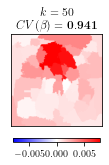

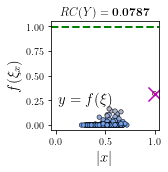

Explanation for		:	 50_True 1 2 3 4 5 6 7 8 9 10 

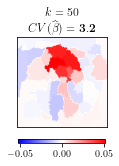

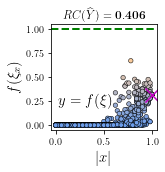

k, max_dist	        :	 100, 4.5318603515625
Explanation for		:	 100_False 1 2 3 4 5 6 7 8 9 10 

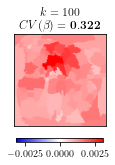

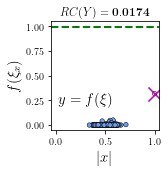

Explanation for		:	 100_True 1 2 3 4 5 6 7 8 9 10 

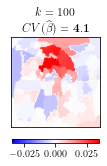

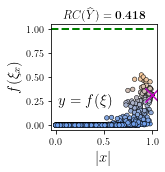

k, max_dist	        :	 150, 4.0130615234375
Explanation for		:	 150_False 1 2 3 4 5 6 7 8 9 10 

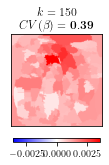

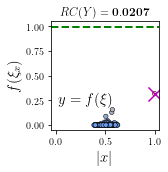

Explanation for		:	 150_True 1 2 3 4 5 6 7 8 9 10 

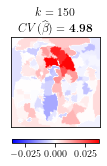

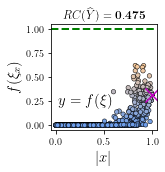

k, max_dist	        :	 200, 3.460693359375
Explanation for		:	 200_False 1 2 3 4 5 6 7 8 9 10 

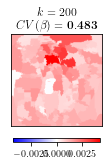

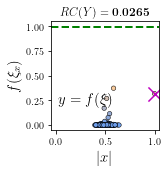

Explanation for		:	 200_True 1 2 3 4 5 6 7 8 9 10 

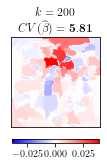

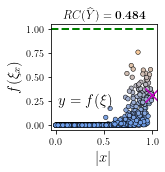

In [16]:
file = os.path.join(DS_path,'ILSVRC2012_test_00000125.JPEG')
image_to_explain = ut.read_process_image(file,model)

predicted = bb_predict(np.array([image_to_explain]))

(predicted_cls_idx,f_x,predicted_cls_lbl) =  ut.get_class_idx_label_score (predicted,class_names)
f_x = predicted[0][predicted_cls_idx]
print('Predicted Class\t\t:\t',predicted_cls_lbl,'\nClass Probability\t:\t', f_x,'\nPredicted Class Index\t:\t', predicted_cls_idx)

for k in [50, 100, 150, 200]:
    max_dist,_,_,_ = ut.search_segment_number(image_to_explain, target_seg_no=k)
    segments,num_segments,segmenter_fn = ut.own_seg(image_to_explain,md=max_dist,ks=4,random_seed=1234,ratio=0.2)

    print(f'k, max_dist\t        :\t {k}, {max_dist}')   
    for use_stratification in [False, True]:
        sig = f'{k}_{use_stratification}'
        lime_explainer = LimeImageExplainer(random_state=1234)
        beta_arr, rcY_arr = [], []
        print('Explanation for\t\t:\t '+sig, end=' ')
        for repeat in range(10):
            print(repeat+1, end=' ')
            ret = lime_explainer.explain_instance(preprocess_input(image_to_explain), bb_predict,
                                                  labels=class_names, segmentation_fn=segmenter_fn,
                                                  top_labels=3, hide_color=None, use_stratification=use_stratification,
                                                  batch_size=100, num_samples=1000, progress_bar=False)
            
            X, all_Ys, expl = ret # when return (data, labels, ret_exp)
            xpld_cls = expl.top_labels[0]
            Y = all_Ys[:, xpld_cls]
            
            beta_arr.append(ut.get_beta_from_expl(expl)) 
            rcY_arr.append(ut.get_RCY(Y, f_x))
            
        beta = np.mean(beta_arr, axis=0)
        
        
        heatmap = ut.heatmap_from_beta(segments, beta)
        v = np.max(np.abs(heatmap))
        fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
        im = ax.imshow(heatmap, cmap='bwr', vmin=-v, vmax=v)
        fig.colorbar(im, ax=ax, shrink=0.55, orientation='horizontal', anchor=(.5, 1.5))
        ut.axis_off(ax)
        beta_title = '\\widehat{\\beta}' if use_stratification else '\\beta'
        plt.title(f'$k = {num_segments}$ \n $CV({beta_title}) = \\mathbf{{ {ut.get_CV_beta(beta):.3} }}$')
        plt.tight_layout()
        plt.savefig(f'{paper_figures}/heatmap_{sig}.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
        plt.savefig(f'{paper_figures}/heatmap_{sig}.png', dpi=150, transparent=True, bbox_inches='tight', pad_inches=0.02)
#         plt.show()
        
        fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
        plt.gca().set_aspect('equal')
        ut.plot_classification_score(ax, expl, X, Y, f_x)
        Y_title = '\\widehat{Y}' if use_stratification else 'Y'
        plt.title(f'$RC({Y_title}) = \\mathbf{{ {np.mean(rcY_arr):.3} }}$')
        plt.tight_layout()
        plt.savefig(f'{paper_figures}/RC_Y_{sig}.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
        plt.savefig(f'{paper_figures}/RC_Y_{sig}.png', dpi=150, transparent=True,bbox_inches='tight', pad_inches=0.02)
        plt.show()

# Generate the comparison plots (Figure 6)
This code starts from the .CSV file of the long experiments, which may take more than 1 day to be computed.

In [17]:
num_samples                 = 1000
segs_list                   = [50,100,150,200]

# Change the filename if you do not want to use the precomputed results' CSV.
df = pd.read_csv (f'result/precomputed_results_1000_1_150_[50, 100, 150, 200].csv', sep=';', index_col=0, 
                 dtype={'Hide_color':str, 'filename':str})

df['IQR0595_Y'] = df.q95_Y - df.q05_Y
df['IQR0199_Y'] = df.q99_Y - df.q01_Y
df['IQR0595_Y_over_fx'] = df.IQR0595_Y / df.f_x
df['IQR0199_Y_over_fx'] = df.IQR0199_Y / df.f_x
df['RC_Y'] = df.IQR0199_Y_over_fx
df['CV_beta'] = df.cv_beta
df.head(3)

,hide_color,use_stratification,num_samples,segments,max_dist,kernal_size,model_name,f_x,g_x,q05_Y,q95_Y,q01_Y,q99_Y,std_Y,std_abs_Y,r2,maxval,local_pred,intercept,std_beta,std_abs_beta,mean_beta,mean_abs_beta,q05_beta,q95_beta,q01_beta,q99_beta,q25_beta,q75_beta,q10_beta,q90_beta,max_beta,min_beta,RC_Y,cv_abs_beta,cv_beta,IQR0595_Y,IQR0199_Y,IQR0595_Y_over_fx,IQR0199_Y_over_fx,CV_beta
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,mean-filled,False,1000,50,7.226562,4,ResNet50,0.999998,1.158471,0.000845,0.923029,0.000225,0.993214,0.306309,0.306309,0.678968,0.263969,[1.15847106],-0.717964,0.061071,0.054012,0.039567,0.048764,-0.026451,0.152443,-0.054870,0.224645,0.001080,0.066055,-0.016561,0.125614,0.263969,-0.060848,0.992991,1.107612,1.543461,0.922184,0.992989,0.922186,0.992991,1.543461
1,mean-filled,True,1000,50,7.226562,4,ResNet50,0.999998,1.110057,0.000116,0.999991,0.000048,0.999998,0.446534,0.446534,0.898626,0.127983,[1.11005696],-0.189856,0.025809,0.024511,0.025739,0.026977,0.001536,0.074437,-0.015488,0.104770,0.007588,0.036046,0.002734,0.055504,0.127983,-0.015929,0.999952,0.908604,1.002720,0.999875,0.999950,0.999877,0.999952,1.002720
1,mean-filled,False,1000,100,3.442383,4,ResNet50,0.999998,0.819516,0.000499,0.639730,0.000117,0.908138,0.206809,0.206809,0.592599,0.142312,[0.81951621],-0.580193,0.027363,0.024522,0.014465,0.018884,-0.012916,0.065831,-0.023956,0.092483,-0.001430,0.022001,-0.008370,0.052944,0.142312,-0.026050,0.908023,1.298583,1.891673,0.639231,0.908021,0.639232,0.908023,1.891673


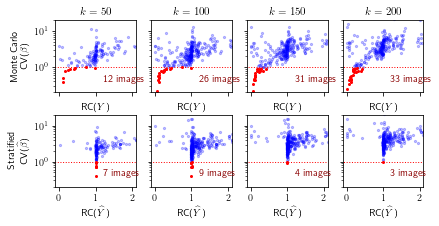

In [18]:
# FIGURE 6  CV PLOTS
fig, ax = plt.subplots(2,4,figsize=(6,3), sharey=True, sharex=False)

for j, sss in enumerate(segs_list):    
    df2 = df[(sss-50 <= df.segments) & (df.segments <= sss) & (df.hide_color =='mean-filled') ].copy()

    df_orig = df2[(df2.use_stratification == False)].sort_values(by='filename')
    df_seg = df2[df2.use_stratification == True].sort_values(by='filename')
    
    x1 = df_orig.RC_Y
    y1 = df_orig.CV_beta  

    x2 = df_seg.RC_Y
    y2 = df_seg.CV_beta 
    
    v = np.max([max(x2), max(y2), max(x1), max(y1)])
    for i in range(2):
        if i==0: ax[i,j].set_xlabel('RC($Y$)')
        if i==1: ax[i,j].set_xlabel('RC($\widehat{Y}$)')
        if j==0 and i==0: ax[i,j].set_ylabel('Monte Carlo\nCV($\\beta$)')
        if j==0 and i==1: ax[i,j].set_ylabel('Stratified\nCV($\\widehat\\beta$)')
        ax[i,j].set_xlim(-0.1, 2.1)
        ax[i,j].set_yscale('log'); ax[i,j].set_ylim(0.2, 20)
        ax[0,j].set_xticks([0,1,2]) ; ax[0,j].set_xticklabels(['', '', ''])
        ax[1,j].set_xticks([0,1,2])
    def scatter_cv(ax, x, y):
        H = 1.0
        sel = (y > H)
        ax.scatter(x[sel], y[sel], s=5, c='blue', alpha=0.25)
        sel = (y <= H) 
        ax.scatter(x[sel], y[sel], s=4, c='red')
        ax.plot([-10,10], [H,H], ls=':', c='red', lw=1)
        ax.text(1.2, 0.4, f'{np.sum(sel)} images', c='darkred')
    scatter_cv(ax[0,j], x1, y1)
    scatter_cv(ax[1,j], x2, y2)
    ax[0,j].set_title(f'$k={sss}$', fontsize=11)
    
plt.tight_layout(pad=0.2, w_pad=0)
plt.savefig(f'{paper_figures}/CV_plots.pdf')
plt.savefig(f'{paper_figures}/CV_plots.png', transparent=True, dpi=150)

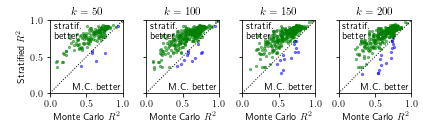

In [19]:
######### FIGURE 6 R2
fig, ax = plt.subplots(1,4,figsize=(6,2), sharey=True, sharex=True)

for j, sss in enumerate(segs_list):    
    df2 = df[(sss-50 <= df.segments) & (df.segments <= sss) & (df.hide_color =='mean-filled') ].copy()

    df_orig = df2[(df2.use_stratification == False)].sort_values(by='filename')
    df_seg = df2[df2.use_stratification == True].sort_values(by='filename')
    
    x = df_orig.r2
    y = df_seg.r2 
    
    ax[j].set_aspect('equal')
    ax[j].set_xlabel('Monte Carlo $R^2$')
    if j==0: ax[j].set_ylabel('\nStratified $R^2$')
    ax[j].set_xlim(0,1)
    ax[j].set_ylim(0,1)
    
    sel = (x >= y)
    ax[j].scatter(x[sel], y[sel], s=5, c='blue', alpha=0.50)
    sel = (x < y)
    ax[j].scatter(x[sel], y[sel], s=5, c='green', alpha=0.50)
    ax[j].plot([0,1], [0,1], ls=':', c='black', lw=1)
    ax[j].text(0.05, 0.75, 'stratif.\nbetter')
    ax[j].text(0.3, 0.05, 'M.C. better')
    ax[j].set_title(f'$k={sss}$', fontsize=11)

plt.tight_layout()
plt.savefig(f'{paper_figures}/R2_plots.pdf')
plt.savefig(f'{paper_figures}/R2_plots.png', transparent=True, dpi=150)

# Generate plots for the selected examples (Figure 7)
This code may take a few hours to complete.

************************************************************************************************************************ 
Running for image no:0/5 image id: 114
Predicted Class		:	 orange 
Class Probability	:	 0.7126368 
Predicted Class Index	:	 950
k = 50  max_dist = 17.1875


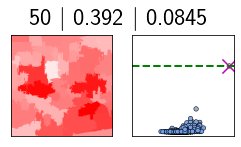

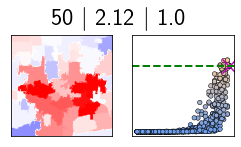

k = 200  max_dist = 5.8837890625


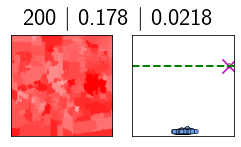

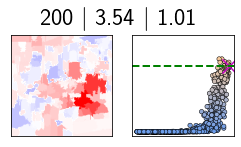

************************************************************************************************************************ 
Running for image no:1/5 image id: 147
Predicted Class		:	 wardrobe 
Class Probability	:	 0.31390327 
Predicted Class Index	:	 894
k = 50  max_dist = 9.375


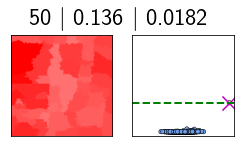

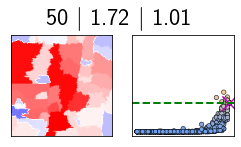

k = 200  max_dist = 4.339599609375


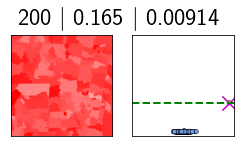

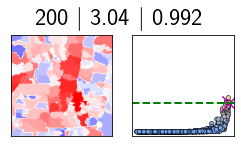

************************************************************************************************************************ 
Running for image no:2/5 image id: 60
Predicted Class		:	 milk_can 
Class Probability	:	 0.762068 
Predicted Class Index	:	 653
k = 50  max_dist = 11.42578125


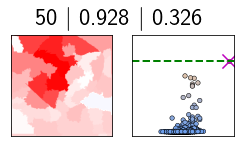

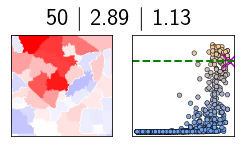

k = 200  max_dist = 4.034423828125


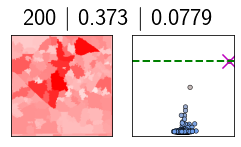

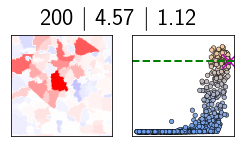

************************************************************************************************************************ 
Running for image no:3/5 image id: 144
Predicted Class		:	 lynx 
Class Probability	:	 0.5038667 
Predicted Class Index	:	 287
k = 50  max_dist = 12.109375


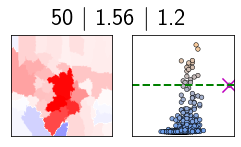

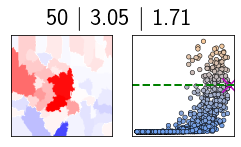

k = 200  max_dist = 4.0130615234375


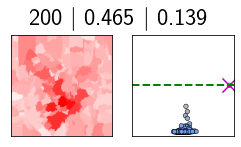

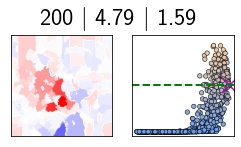

************************************************************************************************************************ 
Running for image no:4/5 image id: 66
Predicted Class		:	 ringneck_snake 
Class Probability	:	 0.36211467 
Predicted Class Index	:	 53
k = 50  max_dist = 9.613037109375


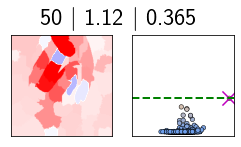

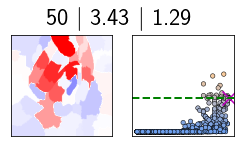

k = 200  max_dist = 3.1622886657714844


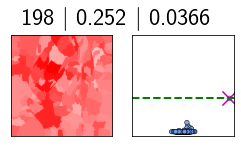

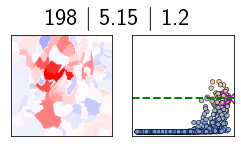

In [20]:
image_no = [
    #orange  wardrobe  milk_can  lynx  ringneck_snake
    114,     147,      60,       144,  66
]
for im_idx,ino in enumerate(image_no):
    
    print('*'*120,f'\nRunning for image no:{im_idx}/{len(image_no)} image id: {ino}')
    file = os.path.join(DS_path,f'ILSVRC2012_test_{ino:08}.JPEG')
    image_to_explain = ut.read_process_image(file,model)
    predicted = bb_predict(np.array([image_to_explain]))
    (predicted_cls_idx,f_x,predicted_cls_lbl) =  ut.get_class_idx_label_score (predicted,class_names)
    f_x = predicted[0][predicted_cls_idx]
    print('Predicted Class\t\t:\t',predicted_cls_lbl,'\nClass Probability\t:\t', f_x,'\nPredicted Class Index\t:\t', predicted_cls_idx)

    for k in [50, 200]:
        max_dist,_,_,_ = ut.search_segment_number(image_to_explain, target_seg_no=k)
        segments,num_segments,segmenter_fn = ut.own_seg(image_to_explain,md=max_dist,ks=4,random_seed=1234,ratio=0.2)
        print(f'k = {k}  max_dist = {max_dist}')
        for use_stratification in [False, True]: 
            lime_explainer = LimeImageExplainer(random_state=1234)
            beta_arr, rcY_arr = [], []
            sig = f'{ino}_{k}_{use_stratification}'
            for repeat in range(10):
                ret = lime_explainer.explain_instance(image_to_explain, bb_predict,
                                                      labels=class_names, segmentation_fn=segmenter_fn,
                                                      top_labels=3, hide_color=None, use_stratification=use_stratification,
                                                      batch_size=500, num_samples=1000, progress_bar=False)
                X, all_Ys, expl = ret # when return (data, labels, ret_exp)
                expainled_cls = expl.top_labels[0]
                Y = all_Ys[:, expainled_cls]
                beta_arr.append(ut.get_beta_from_expl(explanation=expl)) 
                rcY_arr.append(ut.get_RCY(Y, f_x))
            beta = np.mean(beta_arr, axis=0)    
            
            heatmap = ut.heatmap_from_beta(segments=segments, beta=beta)
            fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(4, 2))
            ax1.set_aspect('equal'); ax2.set_aspect('equal')
            ut.axis_off(ax1); ut.axis_off(ax2)
            v = np.max(np.abs(heatmap))
            im = ax1.imshow(heatmap, cmap='bwr', vmin=-v, vmax=v)
            ut.plot_classification_score(ax2, expl, X, Y, f_x, plot_everything=False)
            plt.suptitle(f'{num_segments} $|$ {ut.get_CV_beta(beta):.3} $|$ {np.mean(rcY_arr):.3}', fontsize=24, y=1.05)
            plt.savefig(f'{paper_figures}/dual_{sig}.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
            plt.savefig(f'{paper_figures}/dual_{sig}.png', dpi=150, bbox_inches='tight', pad_inches=0.02)
            plt.show()

************************************************************************************************************************ 
Running for image no:0/2 image id: 19
Predicted Class		:	 chickadee 
Class Probability	:	 0.99888974 
Predicted Class Index	:	 19
k = 50  max_dist = 11.71875


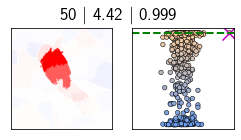

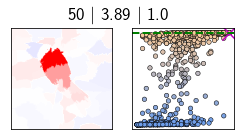

k = 200  max_dist = 4.0130615234375


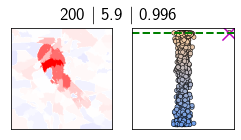

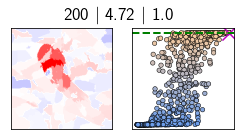

************************************************************************************************************************ 
Running for image no:1/2 image id: 57
Predicted Class		:	 polecat 
Class Probability	:	 0.46934342 
Predicted Class Index	:	 358
k = 50  max_dist = 12.36572265625


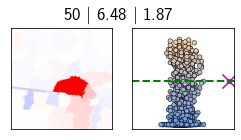

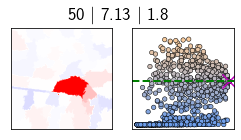

k = 200  max_dist = 4.583740234375


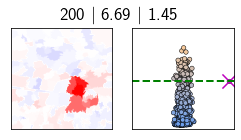

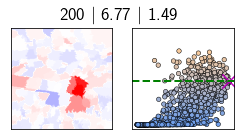

In [23]:
image_no = [
    #orange  wardrobe  milk_can  lynx  ringneck_snake
#     114,     147,      60,       144,  66
    19,57
]
for im_idx,ino in enumerate(image_no):
    
    print('*'*120,f'\nRunning for image no:{im_idx}/{len(image_no)} image id: {ino}')
    file = os.path.join(DS_path,f'ILSVRC2012_test_{ino:08}.JPEG')
    image_to_explain = ut.read_process_image(file,model)
    predicted = bb_predict(np.array([image_to_explain]))
    (predicted_cls_idx,f_x,predicted_cls_lbl) =  ut.get_class_idx_label_score (predicted,class_names)
    f_x = predicted[0][predicted_cls_idx]
    print('Predicted Class\t\t:\t',predicted_cls_lbl,'\nClass Probability\t:\t', f_x,'\nPredicted Class Index\t:\t', predicted_cls_idx)

    for k in [50, 200]:
        max_dist,_,_,_ = ut.search_segment_number(image_to_explain, target_seg_no=k)
        segments,num_segments,segmenter_fn = ut.own_seg(image_to_explain,md=max_dist,ks=4,random_seed=1234,ratio=0.2)
        print(f'k = {k}  max_dist = {max_dist}')
        for use_stratification in [False, True]: 
            lime_explainer = LimeImageExplainer(random_state=1234)
            beta_arr, rcY_arr = [], []
            sig = f'{ino}_{k}_{use_stratification}'
            for repeat in range(1):
                ret = lime_explainer.explain_instance(image_to_explain, bb_predict,
                                                      labels=class_names, segmentation_fn=segmenter_fn,
                                                      top_labels=3, hide_color=None, use_stratification=use_stratification,
                                                      batch_size=500, num_samples=1000, progress_bar=True)
                X, all_Ys, expl = ret # when return (data, labels, ret_exp)
                expainled_cls = expl.top_labels[0]
                Y = all_Ys[:, expainled_cls]
                beta_arr.append(ut.get_beta_from_expl(explanation=expl)) 
                rcY_arr.append(ut.get_RCY(Y, f_x))
            beta = np.mean(beta_arr, axis=0)    
            
            heatmap = ut.heatmap_from_beta(segments=segments, beta=beta)
            fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(4, 2))
            ax1.set_aspect('equal'); ax2.set_aspect('equal')
            ut.axis_off(ax1); ut.axis_off(ax2)
            v = np.max(np.abs(heatmap))
            im = ax1.imshow(heatmap, cmap='bwr', vmin=-v, vmax=v)
            ut.plot_classification_score(ax2, expl, X, Y, f_x, plot_everything=False)
            plt.suptitle(f'{num_segments} $|$ {ut.get_CV_beta(beta):.3} $|$ {np.mean(rcY_arr):.3}', fontsize=18, y=1.00)
            plt.savefig(f'{paper_figures}/dual_{sig}.svg', dpi=150, bbox_inches='tight', pad_inches=0.02)
            plt.savefig(f'{paper_figures}/dual_{sig}.png', dpi=150, bbox_inches='tight', pad_inches=0.02)
            plt.show()